# PCA处理后的因子

使用pca处理资产收益率数据，取其中解释度最高的几个作为因子

In [31]:
import os, sys, argparse, logging

# 设置logging格式和级别
logging.basicConfig(
    # level=logging.DEBUG,
    level=logging.INFO, 
    format='%(filename)s-line%(lineno)d %(levelname)s: %(message)s'
    )

logging.disable(logging.DEBUG)
logging.disable(logging.INFO)

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import pandas as pd
import numpy as np
from datetime import datetime
from copy import deepcopy

from sklearn.decomposition import PCA
from sklearn import preprocessing

import statsmodels.api as sm
import seaborn as sns

logging.disable(logging.NOTSET)

# 首先将framework的目录加进sys.path中，方便使用相对路径导入
framework_path = os.path.join(os.path.abspath(''), '../../../../国君研究所/工作/FOF_portfolio_toolbox/framework')
if framework_path not in sys.path:
    sys.path.append(framework_path)

this_path = os.path.abspath('.')
if this_path not in sys.path:
    sys.path.append(this_path)

from factor_portfolio import *
from load_data import *


## 1. PCA处理因子

In [32]:
# 读入资产数据
date_range = [datetime(2012,1,1), datetime(2021,12,31)]
asset_path = os.path.join(this_path, '../data/assets')
asset_data = pd.read_csv(os.path.join(asset_path, 'asset_prices.csv'), index_col=0)
asset_data.index = pd.to_datetime(asset_data.index)
asset_data = asset_data.loc[date_range[0]: date_range[1]]


In [33]:
asset_data = asset_data.rolling(22, min_periods=1).mean()

asset_return = asset_data.pct_change()
# normalization
mean, std = asset_return.mean(), asset_return.std()
asset_return = (asset_return - mean) / std
asset_return.iloc[0] = 0
asset_return.head(3)



,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
2012-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012-01-05,-1.623239,-4.870095,-0.244173,-0.074636,1.718441,1.337373,4.385931,1.683479
2012-01-06,0.037719,-1.350336,1.141711,0.606436,0.209810,0.095734,2.052404,0.526890


In [34]:
asset_return.corr()

,000300.SH,000905.SH,CBA00651.CS,CBA04031.CS,H11062.CSI,H11063.CSI,H11064.CSI,H11065.CSI
000300.SH,1.000000,0.833272,-0.168694,-0.079934,0.073486,0.250327,0.250967,0.205902
000905.SH,0.833272,1.000000,-0.081898,0.057338,0.007330,0.168563,0.181996,0.129447
CBA00651.CS,-0.168694,-0.081898,1.000000,0.666839,-0.100215,-0.184441,-0.261025,-0.109114
CBA04031.CS,-0.079934,0.057338,0.666839,1.000000,-0.075175,-0.137242,-0.138231,-0.081643
H11062.CSI,0.073486,0.007330,-0.100215,-0.075175,1.000000,0.368121,0.492514,0.344723
H11063.CSI,0.250327,0.168563,-0.184441,-0.137242,0.368121,1.000000,0.721359,0.647198
H11064.CSI,0.250967,0.181996,-0.261025,-0.138231,0.492514,0.721359,1.000000,0.615458
H11065.CSI,0.205902,0.129447,-0.109114,-0.081643,0.344723,0.647198,0.615458,1.000000


In [35]:
# do pca
pca=PCA(n_components=5)  
asset_return_pca = pca.fit_transform(asset_return)
asset_return_pca = pd.DataFrame(asset_return_pca)

asset_return_pca.index = asset_data.index
asset_return_pca.columns = ['factor_{}'.format(i) for i in range(asset_return_pca.shape[1])]

asset_return_pca.head(3)

,factor_0,factor_1,factor_2,factor_3,factor_4
2012-01-04,-3.545604e-16,-1.370603e-14,1.250167e-14,-4.850383e-15,9.134937e-15
2012-01-05,2.402348e+00,5.602740e+00,-2.400722e+00,2.456128e-01,-1.221879e+00
2012-01-06,6.258651e-01,8.846047e-01,-1.773721e+00,2.327741e-01,-4.848745e-01


Text(0.5, 1.0, 'conponents')

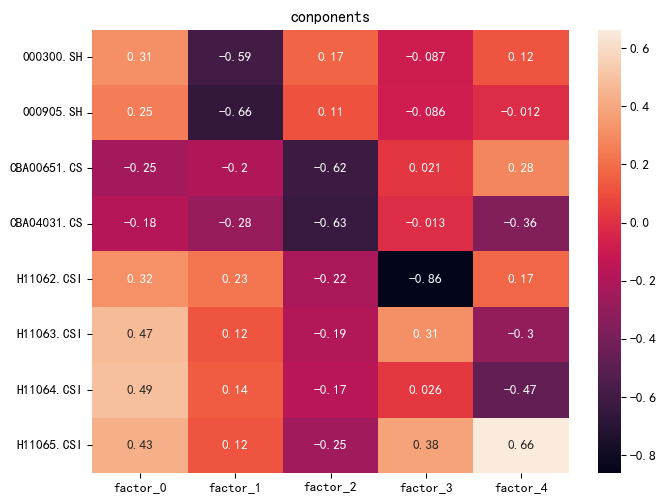

In [36]:
conponents = pd.DataFrame(pca.components_.T, columns=asset_return_pca.columns, index=asset_data.columns)

plt.figure(figsize=(8,6), dpi=96)
sns.heatmap(conponents, annot=True)
plt.title('conponents')

In [37]:
# 解释比例
pca.explained_variance_ratio_

array([0.37333877, 0.20668965, 0.19140542, 0.08870504, 0.04959526])

In [38]:
asset_return_pca.corr()

,factor_0,factor_1,factor_2,factor_3,factor_4
factor_0,1.000000e+00,1.740526e-17,1.105515e-16,-3.366968e-17,-1.300986e-16
factor_1,1.740526e-17,1.000000e+00,-4.473135e-16,2.964121e-17,1.620699e-16
factor_2,1.105515e-16,-4.473135e-16,1.000000e+00,3.376889e-16,2.264245e-16
factor_3,-3.366968e-17,2.964121e-17,3.376889e-16,1.000000e+00,2.455869e-16
factor_4,-1.300986e-16,1.620699e-16,2.264245e-16,2.455869e-16,1.000000e+00


In [39]:
asset_return_pca.iloc[0] = 0
asset_data_pca = asset_return_pca / asset_return_pca.max() * 0.01
#不知道max的大小
asset_data_pca += 1
asset_data_pca = asset_data_pca.cumprod()

<AxesSubplot:title={'center':'asset_data_pca'}>

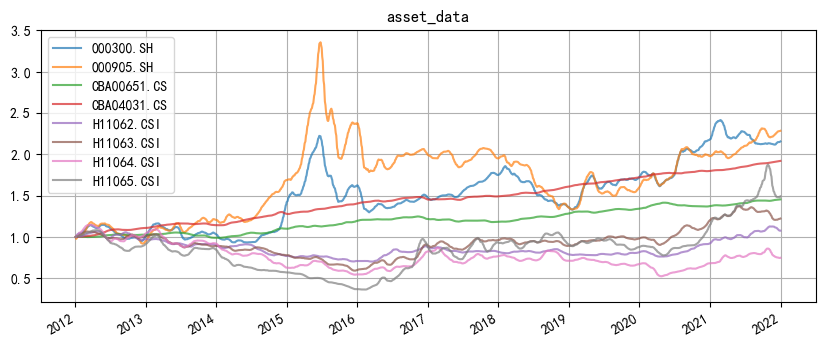

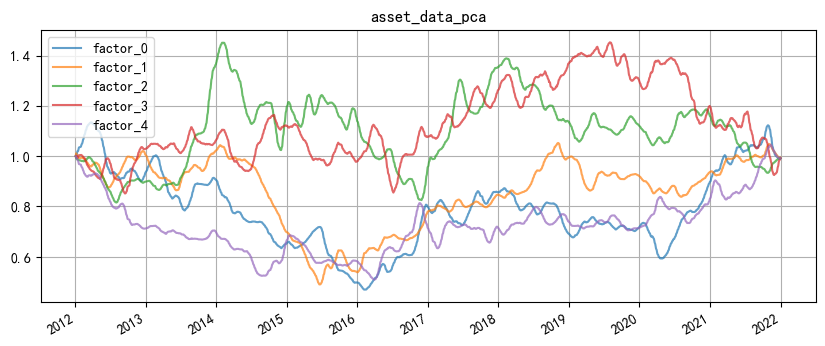

In [40]:
(asset_data / asset_data.iloc[0]).plot(alpha=0.7, grid=True, title='asset_data', figsize=(10, 4))
asset_data_pca.plot(alpha=0.7, grid=True, title='asset_data_pca', figsize=(10, 4))

In [41]:
asset_data_pca.to_csv(os.path.join(this_path, '../data/factors/pca_factors.csv'))

## 2. 显著性检验

每个资产收益分别对pca得到的主成分多元回归

In [42]:
asset_return_pca = (asset_return_pca-asset_return_pca.mean()) / asset_return_pca.std()
asset_return_pca = sm.add_constant(asset_return_pca)

In [43]:
exposure_df = pd.DataFrame(columns=list(asset_return_pca.columns)+['r_squre'])
for column in asset_return.columns:
    est = sm.OLS(asset_return[column], asset_return_pca.astype(float)).fit()
    exposure_df.loc[column] = list(est.params) + [est.rsquared]

# exposure_df

Text(0.5, 1.0, 'OLS results')

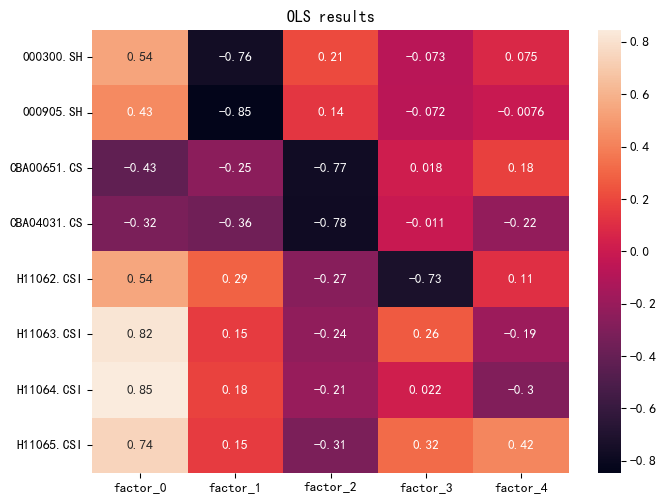

In [44]:
plt.figure(figsize=(8,6), dpi=96)
sns.heatmap(exposure_df.iloc[:, 1:-1], annot=True)
plt.title('OLS results')

In [45]:
# r_squre
exposure_df.iloc[:,-1]

000300.SH      0.921616
000905.SH      0.926241
CBA00651.CS    0.866310
CBA04031.CS    0.891165
H11062.CSI     0.993016
H11063.CSI     0.848271
H11064.CSI     0.880881
H11065.CSI     0.950375
Name: r_squre, dtype: float64